In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'
    
modelname = "densenet121"

Available workers: 16


# Creating train,val,test sets

## Removing outliers

In [3]:
df = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]
# print(df.label.unique())

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10,'other':11}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.label.value_counts()

9     5820
8     5642
7     4575
4     3025
0     2406
3     2390
10    1874
6     1552
5     1087
2     1026
1      711
11     517
Name: label, dtype: int64

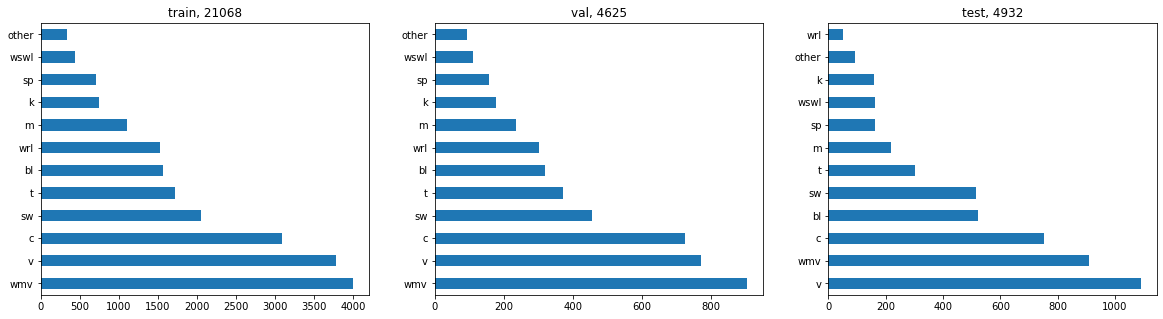

In [4]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(12).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [5]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [6]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [7]:
df_train.label.value_counts()

9     4006
8     3779
7     3098
4     2055
3     1717
0     1563
10    1523
6     1100
5      752
2      706
1      438
11     331
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [8]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
    T.ToPILImage(),
    T.Resize(size=(150,150)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    T.RandomRotation(degrees=(-15,15)),
    T.RandomPosterize(bits=7, p=0.1),
    # T.RandomEqualize(p=0.5),
    T.ToTensor(),
]

transforms_list_test = [
    T.ToPILImage(),
    T.Resize(size=(150,150)),    
    T.ToTensor(),
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=T.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=T.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=T.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

In [9]:
tensor_image = train_dataset[150][0]
# print(tensor_image)
# plt.imshow(  tensor_image.permute(1, 2, 0)  )
# print(tensor_image.permute(1, 2, 0).shape)

#### Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
                            nn.Linear(num_ftrs,512),
                            nn.ReLU(),
                            nn.Dropout(0.3),
                            nn.Linear(512, len(topclasses)))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
if modelname.startswith("mobile"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))

In [12]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 150

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(label_smoothing=.15, weight=torch.Tensor(weight).cuda())

Train on gpu: True


In [13]:
optimizer = optim.AdamW(model.parameters(), lr=.003, weight_decay=0.01)#optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.03, cycle_momentum=False, mode="triangular2")

In [14]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [15]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:06<00:00, 23.58it/s]


Epoch 0: train_acc: 57.9% loss: 1.4414058,  val_loss: 1.8829389 val_acc: 62.6%
Validation accuracy improved from 0.00 to 62.55. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.97it/s]


Epoch 1: train_acc: 68.7% loss: 2.1219785,  val_loss: 1.8272021 val_acc: 74.5%
Validation accuracy improved from 62.55 to 74.46. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.68it/s]


Epoch 2: train_acc: 72.0% loss: 1.9330249,  val_loss: 1.5995378 val_acc: 73.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.83it/s]


Epoch 3: train_acc: 73.5% loss: 1.9242177,  val_loss: 1.8062263 val_acc: 76.0%
Validation accuracy improved from 74.46 to 76.00. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.75it/s]


Epoch 4: train_acc: 75.6% loss: 1.5783423,  val_loss: 1.5831172 val_acc: 76.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.32it/s]


Epoch 5: train_acc: 76.1% loss: 1.7822771,  val_loss: 1.4385154 val_acc: 75.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.20it/s]


Epoch 6: train_acc: 76.6% loss: 2.1318533,  val_loss: 1.6753689 val_acc: 76.8%
Validation accuracy improved from 76.00 to 76.78. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.25it/s]


Epoch 7: train_acc: 77.3% loss: 1.1119876,  val_loss: 1.4604208 val_acc: 76.9%
Validation accuracy improved from 76.78 to 76.86. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.27it/s]


Epoch 8: train_acc: 78.6% loss: 1.6010499,  val_loss: 1.4522821 val_acc: 76.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.29it/s]


Epoch 9: train_acc: 78.2% loss: 1.6153607,  val_loss: 1.6517184 val_acc: 78.0%
Validation accuracy improved from 76.86 to 78.03. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.30it/s]


Epoch 10: train_acc: 78.7% loss: 1.5187566,  val_loss: 1.4677268 val_acc: 77.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.19it/s]


Epoch 11: train_acc: 79.1% loss: 1.2072083,  val_loss: 1.9454147 val_acc: 78.9%
Validation accuracy improved from 78.03 to 78.90. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.16it/s]


Epoch 12: train_acc: 79.8% loss: 1.7639971,  val_loss: 1.5374786 val_acc: 77.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.28it/s]


Epoch 13: train_acc: 79.8% loss: 1.3583288,  val_loss: 1.6257026 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.40it/s]


Epoch 14: train_acc: 80.5% loss: 1.4966416,  val_loss: 1.6042135 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.28it/s]


Epoch 15: train_acc: 80.6% loss: 1.4042907,  val_loss: 2.0255747 val_acc: 80.3%
Validation accuracy improved from 78.90 to 80.26. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.26it/s]


Epoch 16: train_acc: 80.7% loss: 2.1757026,  val_loss: 1.5790794 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.27it/s]


Epoch 17: train_acc: 81.0% loss: 1.2670298,  val_loss: 1.4733562 val_acc: 76.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.25it/s]


Epoch 18: train_acc: 81.1% loss: 1.3990785,  val_loss: 1.4763439 val_acc: 76.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.29it/s]


Epoch 19: train_acc: 81.7% loss: 1.4765370,  val_loss: 1.8476491 val_acc: 70.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 20: train_acc: 81.4% loss: 2.5194116,  val_loss: 1.7883475 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.31it/s]


Epoch 21: train_acc: 81.9% loss: 2.4283724,  val_loss: 1.5811946 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.31it/s]


Epoch 22: train_acc: 81.8% loss: 1.1142837,  val_loss: 1.6495348 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 23: train_acc: 82.7% loss: 1.4260190,  val_loss: 1.5307461 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.36it/s]


Epoch 24: train_acc: 82.8% loss: 1.4797459,  val_loss: 1.8247013 val_acc: 75.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.40it/s]


Epoch 25: train_acc: 82.2% loss: 1.4869465,  val_loss: 1.6689357 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.37it/s]


Epoch 26: train_acc: 82.7% loss: 1.4584554,  val_loss: 1.9941440 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 24.97it/s]


Epoch 27: train_acc: 83.3% loss: 1.0861288,  val_loss: 1.7506567 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.28it/s]


Epoch 28: train_acc: 82.6% loss: 1.4109800,  val_loss: 1.8919122 val_acc: 80.8%
Validation accuracy improved from 80.26 to 80.82. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 29: train_acc: 83.2% loss: 1.6564348,  val_loss: 1.5298328 val_acc: 73.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 30: train_acc: 82.9% loss: 1.2838626,  val_loss: 1.8097034 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.21it/s]


Epoch 31: train_acc: 82.9% loss: 1.3843780,  val_loss: 1.6904640 val_acc: 79.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.19it/s]


Epoch 32: train_acc: 83.9% loss: 1.2054603,  val_loss: 1.4559178 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.25it/s]


Epoch 33: train_acc: 83.5% loss: 1.4899580,  val_loss: 2.2373915 val_acc: 79.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.98it/s]


Epoch 34: train_acc: 83.9% loss: 1.4565740,  val_loss: 1.9951038 val_acc: 77.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 35: train_acc: 83.8% loss: 1.4447041,  val_loss: 1.5538875 val_acc: 74.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 36: train_acc: 84.4% loss: 0.9839176,  val_loss: 1.4875169 val_acc: 81.0%
Validation accuracy improved from 80.82 to 80.97. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 37: train_acc: 84.2% loss: 1.2495277,  val_loss: 1.6588800 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.40it/s]


Epoch 38: train_acc: 84.5% loss: 1.9925866,  val_loss: 1.3885211 val_acc: 78.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 39: train_acc: 84.7% loss: 1.1988268,  val_loss: 1.5091028 val_acc: 79.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 40: train_acc: 84.8% loss: 2.2618895,  val_loss: 1.8042939 val_acc: 80.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 41: train_acc: 84.9% loss: 1.1627524,  val_loss: 1.6154987 val_acc: 64.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 27.96it/s]


Epoch 42: train_acc: 84.8% loss: 1.5196428,  val_loss: 1.9173023 val_acc: 80.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.40it/s]


Epoch 43: train_acc: 85.0% loss: 1.4763618,  val_loss: 1.6615462 val_acc: 80.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.23it/s]


Epoch 44: train_acc: 85.2% loss: 1.5772433,  val_loss: 1.7523820 val_acc: 81.3%
Validation accuracy improved from 80.97 to 81.25. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 45: train_acc: 85.6% loss: 1.2430232,  val_loss: 2.0066600 val_acc: 79.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.36it/s]


Epoch 46: train_acc: 85.6% loss: 1.1963919,  val_loss: 1.8558965 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.37it/s]


Epoch 47: train_acc: 85.7% loss: 1.2088919,  val_loss: 1.6579177 val_acc: 69.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.29it/s]


Epoch 48: train_acc: 85.8% loss: 1.3436819,  val_loss: 2.0050659 val_acc: 81.6%
Validation accuracy improved from 81.25 to 81.56. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.36it/s]


Epoch 49: train_acc: 85.1% loss: 1.0625937,  val_loss: 1.9110609 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.45it/s]


Epoch 50: train_acc: 85.8% loss: 1.1909369,  val_loss: 2.1338027 val_acc: 81.8%
Validation accuracy improved from 81.56 to 81.79. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.31it/s]


Epoch 51: train_acc: 85.8% loss: 1.1728172,  val_loss: 1.4185019 val_acc: 73.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 52: train_acc: 85.6% loss: 1.5668921,  val_loss: 1.9194555 val_acc: 79.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 53: train_acc: 86.3% loss: 1.1863803,  val_loss: 1.8051351 val_acc: 81.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 54: train_acc: 86.0% loss: 1.5647171,  val_loss: 1.7943523 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.36it/s]


Epoch 55: train_acc: 86.0% loss: 1.8007708,  val_loss: 1.8345493 val_acc: 81.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.29it/s]


Epoch 56: train_acc: 87.0% loss: 1.1077709,  val_loss: 2.0929642 val_acc: 66.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.36it/s]


Epoch 57: train_acc: 86.5% loss: 1.0915433,  val_loss: 1.8824129 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.46it/s]


Epoch 58: train_acc: 85.7% loss: 1.2856646,  val_loss: 1.9408860 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 59: train_acc: 86.2% loss: 1.4230917,  val_loss: 1.9017203 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 60: train_acc: 86.7% loss: 1.3151613,  val_loss: 1.5595706 val_acc: 77.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 61: train_acc: 86.6% loss: 1.8867843,  val_loss: 1.8412273 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 62: train_acc: 86.4% loss: 1.2133740,  val_loss: 1.9617956 val_acc: 80.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.34it/s]


Epoch 63: train_acc: 86.7% loss: 1.5823326,  val_loss: 2.1112325 val_acc: 78.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 64: train_acc: 86.3% loss: 1.1491307,  val_loss: 1.5655448 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.30it/s]


Epoch 65: train_acc: 87.2% loss: 1.3557814,  val_loss: 1.9208143 val_acc: 82.2%
Validation accuracy improved from 81.79 to 82.21. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 66: train_acc: 86.1% loss: 1.5236295,  val_loss: 1.3808966 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.32it/s]


Epoch 67: train_acc: 87.2% loss: 1.5188875,  val_loss: 1.8491079 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 68: train_acc: 87.1% loss: 1.3956691,  val_loss: 1.5495284 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 69: train_acc: 87.5% loss: 1.3931355,  val_loss: 1.8807721 val_acc: 80.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 70: train_acc: 87.5% loss: 1.3003913,  val_loss: 1.7166506 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 71: train_acc: 87.5% loss: 1.8015499,  val_loss: 1.4634992 val_acc: 76.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.30it/s]


Epoch 72: train_acc: 86.9% loss: 1.7788811,  val_loss: 2.0060599 val_acc: 81.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 73: train_acc: 87.3% loss: 0.9465722,  val_loss: 2.0999951 val_acc: 71.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.58it/s]


Epoch 74: train_acc: 87.3% loss: 1.6098807,  val_loss: 1.7431190 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 75: train_acc: 87.6% loss: 1.0343156,  val_loss: 1.4579428 val_acc: 75.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 76: train_acc: 87.3% loss: 2.3238640,  val_loss: 1.7691863 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 77: train_acc: 87.6% loss: 1.2578659,  val_loss: 1.8409356 val_acc: 81.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.41it/s]


Epoch 78: train_acc: 87.8% loss: 1.1425047,  val_loss: 1.7801685 val_acc: 80.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.34it/s]


Epoch 79: train_acc: 87.6% loss: 1.7052238,  val_loss: 1.9159729 val_acc: 81.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.52it/s]


Epoch 80: train_acc: 88.2% loss: 1.1991754,  val_loss: 1.9295503 val_acc: 76.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.40it/s]


Epoch 81: train_acc: 88.0% loss: 1.9861901,  val_loss: 1.4600419 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.56it/s]


Epoch 82: train_acc: 87.3% loss: 1.2883328,  val_loss: 2.0682085 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.47it/s]


Epoch 83: train_acc: 88.1% loss: 1.2656093,  val_loss: 1.3616604 val_acc: 82.7%
Validation accuracy improved from 82.21 to 82.75. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.55it/s]


Epoch 84: train_acc: 88.3% loss: 1.1982324,  val_loss: 1.9083970 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 85: train_acc: 87.8% loss: 1.5524195,  val_loss: 1.7965676 val_acc: 74.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.52it/s]


Epoch 86: train_acc: 88.2% loss: 1.2270857,  val_loss: 1.6266863 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.46it/s]


Epoch 87: train_acc: 88.4% loss: 0.9570750,  val_loss: 1.6647809 val_acc: 78.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 88: train_acc: 87.8% loss: 1.7066293,  val_loss: 1.7289671 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.10it/s]


Epoch 89: train_acc: 88.6% loss: 1.2941647,  val_loss: 1.7807703 val_acc: 82.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.30it/s]


Epoch 90: train_acc: 88.4% loss: 1.4618783,  val_loss: 1.8035251 val_acc: 80.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 91: train_acc: 88.7% loss: 1.4665188,  val_loss: 1.7628099 val_acc: 80.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 92: train_acc: 88.4% loss: 1.1365041,  val_loss: 2.2012925 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.45it/s]


Epoch 93: train_acc: 88.3% loss: 1.0359110,  val_loss: 1.7013428 val_acc: 81.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 94: train_acc: 88.4% loss: 1.9136137,  val_loss: 2.0023952 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 95: train_acc: 88.8% loss: 1.1164832,  val_loss: 1.9137119 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.46it/s]


Epoch 96: train_acc: 88.9% loss: 1.5451027,  val_loss: 1.5494909 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 97: train_acc: 88.8% loss: 1.6876515,  val_loss: 1.7367141 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.47it/s]


Epoch 98: train_acc: 88.4% loss: 1.0457720,  val_loss: 1.7907867 val_acc: 77.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.52it/s]


Epoch 99: train_acc: 89.5% loss: 1.5691588,  val_loss: 1.9913008 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 100: train_acc: 88.4% loss: 0.9573735,  val_loss: 1.4319279 val_acc: 76.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.40it/s]


Epoch 101: train_acc: 87.8% loss: 1.0309832,  val_loss: 2.0221093 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.53it/s]


Epoch 102: train_acc: 88.5% loss: 1.6219518,  val_loss: 2.0614991 val_acc: 81.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.53it/s]


Epoch 103: train_acc: 89.3% loss: 1.1549248,  val_loss: 1.5848780 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.50it/s]


Epoch 104: train_acc: 88.9% loss: 2.0029378,  val_loss: 1.5165529 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 105: train_acc: 89.0% loss: 1.5299132,  val_loss: 1.6717389 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.50it/s]


Epoch 106: train_acc: 89.0% loss: 1.7421174,  val_loss: 1.8172729 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.50it/s]


Epoch 107: train_acc: 88.8% loss: 1.6836498,  val_loss: 1.8952225 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.49it/s]


Epoch 108: train_acc: 88.5% loss: 1.3234243,  val_loss: 1.3654824 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.48it/s]


Epoch 109: train_acc: 89.0% loss: 1.3290958,  val_loss: 1.4135857 val_acc: 78.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.28it/s]


Epoch 110: train_acc: 88.8% loss: 1.4933710,  val_loss: 1.9624989 val_acc: 77.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.37it/s]


Epoch 111: train_acc: 89.7% loss: 1.7214226,  val_loss: 1.7631266 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.29it/s]


Epoch 112: train_acc: 89.3% loss: 1.6597850,  val_loss: 1.4886992 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.42it/s]


Epoch 113: train_acc: 88.7% loss: 1.0884259,  val_loss: 1.4297194 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.48it/s]


Epoch 114: train_acc: 89.8% loss: 0.9553796,  val_loss: 1.4924440 val_acc: 77.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 115: train_acc: 89.1% loss: 1.0493596,  val_loss: 2.0821154 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.52it/s]


Epoch 116: train_acc: 89.5% loss: 1.0423222,  val_loss: 2.1047244 val_acc: 81.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.58it/s]


Epoch 117: train_acc: 88.6% loss: 1.5767548,  val_loss: 1.5279917 val_acc: 81.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.50it/s]


Epoch 118: train_acc: 89.2% loss: 1.5231073,  val_loss: 1.5263972 val_acc: 81.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.59it/s]


Epoch 119: train_acc: 90.2% loss: 1.8549480,  val_loss: 2.1544311 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.57it/s]


Epoch 120: train_acc: 89.0% loss: 1.9178457,  val_loss: 1.4331660 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 121: train_acc: 89.2% loss: 1.1854739,  val_loss: 2.2011373 val_acc: 82.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.45it/s]


Epoch 122: train_acc: 89.1% loss: 1.1918497,  val_loss: 1.9903674 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.33it/s]


Epoch 123: train_acc: 89.2% loss: 1.4030664,  val_loss: 1.9654884 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.35it/s]


Epoch 124: train_acc: 89.8% loss: 1.4097698,  val_loss: 1.6985383 val_acc: 78.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.49it/s]


Epoch 125: train_acc: 88.4% loss: 1.4391286,  val_loss: 1.4908049 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.32it/s]


Epoch 126: train_acc: 89.4% loss: 1.5523400,  val_loss: 1.8233483 val_acc: 79.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.48it/s]


Epoch 127: train_acc: 89.9% loss: 1.4319013,  val_loss: 1.6881380 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.58it/s]


Epoch 128: train_acc: 88.8% loss: 1.3277879,  val_loss: 1.9089425 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.43it/s]


Epoch 129: train_acc: 89.8% loss: 1.0323914,  val_loss: 1.5193152 val_acc: 78.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.18it/s]


Epoch 130: train_acc: 89.7% loss: 1.2662765,  val_loss: 1.4419508 val_acc: 80.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.59it/s]


Epoch 131: train_acc: 89.7% loss: 1.8652325,  val_loss: 2.1420026 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.46it/s]


Epoch 132: train_acc: 89.6% loss: 1.2488906,  val_loss: 1.8932481 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.41it/s]


Epoch 133: train_acc: 89.5% loss: 1.1718514,  val_loss: 1.4186414 val_acc: 79.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.39it/s]


Epoch 134: train_acc: 88.9% loss: 1.0678759,  val_loss: 2.2039413 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.45it/s]


Epoch 135: train_acc: 89.4% loss: 1.3005658,  val_loss: 1.7744396 val_acc: 81.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 136: train_acc: 90.0% loss: 1.5672730,  val_loss: 2.0800002 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.38it/s]


Epoch 137: train_acc: 89.3% loss: 1.7090677,  val_loss: 1.4309461 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 138: train_acc: 89.6% loss: 0.9217592,  val_loss: 1.5260515 val_acc: 76.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 139: train_acc: 89.2% loss: 1.3778713,  val_loss: 1.8535171 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.44it/s]


Epoch 140: train_acc: 90.2% loss: 1.6372998,  val_loss: 2.1264262 val_acc: 77.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.35it/s]


Epoch 141: train_acc: 90.2% loss: 1.8901346,  val_loss: 2.1098652 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.56it/s]


Epoch 142: train_acc: 89.3% loss: 1.7279700,  val_loss: 2.0530260 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.52it/s]


Epoch 143: train_acc: 88.7% loss: 1.2538755,  val_loss: 2.1663482 val_acc: 81.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.47it/s]


Epoch 144: train_acc: 89.2% loss: 1.8292563,  val_loss: 2.1100438 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.18it/s]


Epoch 145: train_acc: 89.4% loss: 1.7822973,  val_loss: 1.8905149 val_acc: 79.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.45it/s]


Epoch 146: train_acc: 90.1% loss: 1.0201823,  val_loss: 1.9706634 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 147: train_acc: 89.3% loss: 2.3663256,  val_loss: 1.8899052 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.51it/s]


Epoch 148: train_acc: 89.4% loss: 1.3541157,  val_loss: 1.7993855 val_acc: 76.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:05<00:00, 28.55it/s]


Epoch 149: train_acc: 89.6% loss: 1.9507551,  val_loss: 2.0556173 val_acc: 80.9%


In [16]:
x_batch[0].shape

torch.Size([3, 150, 150])

In [17]:
train_dataset